<a href="https://colab.research.google.com/github/edwardcdy/deep-learning-notebooks/blob/main/Machine_Translation_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn, Tensor
from torch.utils.data import dataset, DataLoader
import torch.nn.functional as F

from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import tqdm

In [ ]:
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import Multi30k
from typing import Iterable, List


SRC_LANGUAGE = 'de'
TGT_LANGUAGE = 'en'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

100%|██████████| 1.21M/1.21M [00:04<00:00, 301kB/s]


In [ ]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

In [85]:
BATCH_SIZE = 32

train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
train_data = to_map_style_dataset(train_iter)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Simple feedforward model

In [ ]:
class FF(nn.Module):
  
  def __init__(self, input_vocab_size: int, target_vocab_size: int, max_seq_len: int = 30):
    super().__init__()
    self.lookup = nn.Embedding(input_vocab_size, 10)
    self.fc1 = nn.Linear(max_seq_len * 10, max_seq_len * 20)
    self.fc2 = nn.Linear(max_seq_len * 20, max_seq_len * 20)
    self.fc3 = nn.Linear(max_seq_len * 20, max_seq_len * target_vocab_size)

  def forward(self, x):
    batch_size, max_seq_len = x.shape
    embedded = self.lookup(x)
    x = embedded.reshape(batch_size, max_seq_len * 10)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x).reshape((batch_size, max_seq_len, -1))
    return F.log_softmax(x, dim=2)


In [90]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(net: nn.Module, epochs: int = 20):
  net.train()
  opt = torch.optim.Adam(net.parameters(), lr=3e-4)
  loss = torch.nn.NLLLoss()

  ret = []

  for e in tqdm.tqdm(range(epochs)):
    t = 0


    for x,y in train_dataloader:
      net.zero_grad()

      x, y = scale_transpose_seqs(x, y)

      out = net(x)

      l = loss(out.swapaxes(1,2), y)

      l.backward()
      opt.step()

      t += l.item()

    ret.append(t)

    if e % 5 == 0:
      print(f"Epoch {e}: loss {t}")

  return ret

def scale_transpose_seqs(x: torch.Tensor, y: torch.Tensor, max_length: int = 30):
  if x.shape[0] < max_length:
    add = torch.full((max_length - x.shape[0], x.shape[1]), PAD_IDX)
    x = torch.cat((x, add), dim=0)
  elif x.shape[0] > max_length:
    x = x[:max_length, :]

  if y.shape[0] < max_length:
    add = torch.full((max_length - y.shape[0], y.shape[1]), PAD_IDX)
    y = torch.cat((y, add), dim=0)
  elif y.shape[0] > max_length:
    y = y[:max_length, :]

  return x.to(device).long().T, y.to(device).long().T

In [92]:
in_vocab = len(vocab_transform[SRC_LANGUAGE])
out_vocab = len(vocab_transform[TGT_LANGUAGE])

net = FF(in_vocab, out_vocab).to(device)

errors = train(net, 20)

  5%|▌         | 1/20 [00:50<15:50, 50.05s/it]

Epoch 0: loss 2430.334601163864


 30%|███       | 6/20 [05:00<11:40, 50.05s/it]

Epoch 5: loss 1227.56438934803


 55%|█████▌    | 11/20 [09:10<07:30, 50.04s/it]

Epoch 10: loss 782.5878782272339


 80%|████████  | 16/20 [13:20<03:20, 50.05s/it]

Epoch 15: loss 576.3457290828228


100%|██████████| 20/20 [16:41<00:00, 50.05s/it]


[2430.334601163864,
 1961.319573044777,
 1791.9127801656723,
 1617.3322771787643,
 1406.2334730625153,
 1227.56438934803,
 1098.5739295482635,
 997.2524153590202,
 912.7117967307568,
 842.493296533823,
 782.5878782272339,
 730.7394541203976,
 685.1782786101103,
 644.9187347888947,
 608.8551669120789,
 576.3457290828228,
 546.412243142724,
 519.1345553547144,
 493.9023108333349,
 470.5266042351723]

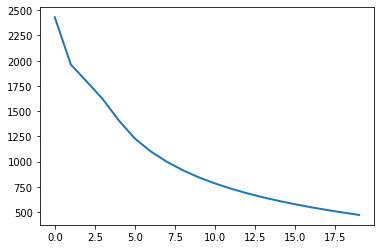

In [94]:
import matplotlib.pyplot as plt
import numpy as np
# plot
fig, ax = plt.subplots()
ax.plot(np.arange(20), errors, linewidth=2.0)
plt.show()

In [109]:
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 1

valid_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
valid_dataloader = DataLoader(to_map_style_dataset(valid_iter), batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)


def example_translations(net: nn.Module, n_samples: int): 
  net.eval()

  english = vocab_transform[TGT_LANGUAGE].get_itos()
  german = vocab_transform[SRC_LANGUAGE].get_itos()

  count = 0
  for x,y in valid_dataloader:
    print(f'Source sentence: {" ".join(map(lambda a: german[a], x))}')
    print(f'Ground truth: {" ".join(map(lambda a: english[a], y))}')
    x, _ = scale_transpose_seqs(x,y)
    out = net(x)

    print(f'Translated sentence: {" ".join(map(lambda a: english[a.argmax()], out.squeeze()))}')
    print("\n")
    count += 1
    if count == n_samples:
      break


In [110]:
example_translations(net, 5)

Source sentence: <bos> Ein Vogel fliegt über das Wasser . <eos>
Ground truth: <bos> A bird flies across the water . <eos>
Translated sentence: <bos> A male is posing the the water . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Zwei Menschen überqueren eine Straße . <eos>
Ground truth: <bos> Two people walking across a street . <eos>
Translated sentence: <bos> Two people children on welding playing <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


Source sentence: <bos> Eine Gruppe von Mädchen spielt in einem Springbrunnen in der Sonne . <eos>
Ground truth: <bos> A group of girls are playing in a water fountain in the sun . <eos>
Translated sentence: <bos> A group of adults bask in playing sun . <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad